In [23]:
%matplotlib inline
#导入相关依赖库
from matplotlib import pyplot
import numpy as np
import os
import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import  LossMonitor, CheckpointConfig, ModelCheckpoint
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig
from mindspore import load_checkpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mindspore.ops import operations as P

In [24]:
DATA_DIR_TRAIN = "D:/DL/MNIST/MNIST/train" # 训练集信息
DATA_DIR_TEST = "D:/DL/MNIST/MNIST/test" # 测试集信息
DATA_DIR = "D:/DL/MNIST/MNIST"

In [25]:
def create_dataset(training=True, batch_size=32, resize=(32, 32),rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64,drop_remainder = True):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    

    resize_op = CV.Resize(resize)
    #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder)
    
    return ds

In [26]:
class ResidualBlock(nn.Cell):
    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1):
        super(ResidualBlock, self).__init__()
        channel = out_channel
        self.conv1 = nn.Conv2d(in_channel, channel,kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel,kernel_size=3, stride=stride)
        self.bn2 = nn.BatchNorm2d(channel)
        self.conv3 = nn.Conv2d(channel, out_channel,kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.down_sample = False
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([nn.Conv2d(channel, out_channel,kernel_size=1, stride=1),
                                                        nn.BatchNorm2d(out_channel)])
        self.add = P.Add()
    def construct(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        out = self.add(out, identity)
        out = self.relu(out)
        return out

In [27]:
class CNN(nn.Cell):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, stride=1, pad_mode='same')
        self.conv2 = nn.Conv2d(6, 16, 3, stride=1, pad_mode='same')
        self.res1 = ResidualBlock(6, 6, stride=1)
        self.res2 = ResidualBlock(16, 16, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(16*8*8, 120,activation='relu')
        self.fc2 = nn.Dense(120, 84,activation='relu')
        self.fc3 = nn.Dense(84, 10)
        self.dropout = nn.Dropout(0.9)
    #构建网络
    def construct(self, x):
        x = self.relu(self.res1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.res2(self.conv2(x)))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x,)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [28]:
# net = ResidualBlock(1, 6, stride=1)
# print(net)
# input = ms.Tensor(np.ones([1, 1, 32, 32]), ms.float32)
# output = net(input)
# print(output.shape)

In [29]:
def train(lr=0.01, momentum=0.9, num_epochs=3):
    ds_train = create_dataset(training=True,batch_size=32)
    net = CNN()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(net.trainable_params(), lr, momentum)
    loss_cb = LossMonitor(per_print_times=ds_train.get_dataset_size())
    metrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
    model = Model(net, loss, opt, metrics=metrics)
    model.train(num_epochs, ds_train, callbacks=[loss_cb], dataset_sink_mode=False)
    return model
model = train()

epoch: 1 step: 1875, loss is 0.20250794291496277
epoch: 2 step: 1875, loss is 0.008436259813606739
epoch: 3 step: 1875, loss is 0.008808090351521969


In [30]:
def test(model):
    ds_eval = create_dataset(training=False,drop_remainder=False)
    metrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
    metrics = model.eval(ds_eval, dataset_sink_mode=False)
    print('Metrics:', metrics)
test(model)

Metrics: {'accuracy': 0.9827, 'loss': 0.05342913310626706, 'precision': array([0.98487903, 0.98598949, 0.97898758, 0.97365854, 0.99381443,
       0.98100559, 0.99263158, 0.97115385, 0.97843943, 0.98756477]), 'recall': array([0.99693878, 0.99207048, 0.99321705, 0.98811881, 0.98167006,
       0.98430493, 0.98434238, 0.98249027, 0.97843943, 0.9444995 ]), 'f1_score': array([0.99087221, 0.98902064, 0.98605099, 0.98083538, 0.98770492,
       0.98265249, 0.9884696 , 0.97678917, 0.97843943, 0.96555218])}


In [31]:
cifar_ds = create_dataset(training=False, batch_size=32,drop_remainder=False)
test_label = []
test_pred = []
for data in cifar_ds.create_dict_iterator(num_epochs=3, output_numpy=True):
    test_label.extend(data['label'])
    input_img = ms.Tensor(data['image'])
    output = model.predict(input_img)
    output = nn.Softmax(axis=1)(output)
    pred = output.asnumpy()
    pred = np.argmax(pred, axis=1)
    test_pred.extend(pred)

In [32]:
cm = confusion_matrix(test_label, test_pred,normalize='true')
cm

array([[9.96938776e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.02040816e-03, 1.02040816e-03,
        1.02040816e-03, 0.00000000e+00],
       [0.00000000e+00, 9.92070485e-01, 2.64317181e-03, 1.76211454e-03,
        0.00000000e+00, 8.81057269e-04, 1.76211454e-03, 0.00000000e+00,
        8.81057269e-04, 0.00000000e+00],
       [1.93798450e-03, 0.00000000e+00, 9.93217054e-01, 0.00000000e+00,
        9.68992248e-04, 0.00000000e+00, 0.00000000e+00, 3.87596899e-03,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.95049505e-03, 9.88118812e-01,
        0.00000000e+00, 2.97029703e-03, 0.00000000e+00, 9.90099010e-04,
        2.97029703e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.03665988e-03, 0.00000000e+00,
        9.81670061e-01, 0.00000000e+00, 2.03665988e-03, 1.01832994e-03,
        3.05498982e-03, 1.01832994e-02],
       [2.24215247e-03, 0.00000000e+00, 0.00000000e+00, 8.96860987e-03,
   

<AxesSubplot:>

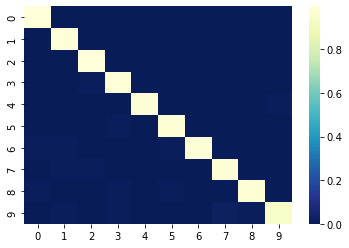

In [33]:
sns.heatmap(cm,cmap="YlGnBu_r")